In [31]:
m = fsspec.get_mapper("http://macadamia.bgc-jena.mpg.de:9052")
g = zarr.open_consolidated(m)

In [32]:
batch = g["batches"][1,:,:,:]

In [33]:
batch.shape

(100, 3, 736)

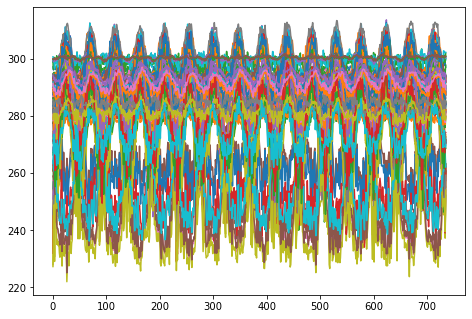

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for i in range(100):
    ax.plot(batch[i,2,:])